In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import json
from datetime import datetime,timedelta
import dateutil.parser
import dateutil.rrule
import numpy as np
import pandas as pd
import xarray as xr
from metgrs import Utils
import io
import math
import types
import glob
import matplotlib as mpl
from joblib import Parallel,delayed
from metgrs import Lidar
import matplotlib.pyplot as plt

In [2]:
datapath='../datas/'

In [3]:
fs=glob.glob(datapath+'/LidarFiles/20241204/LIDAR_RAW/*.BIN')

In [4]:
fs

['../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160000_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160100_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160200_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160300_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160400_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160500_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160600_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160700_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160800_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_I_57461_20241203160900_O_LIDAR_YLJ1_L0.BIN',
 '../datas//LidarFiles/20241204/LIDAR_RAW\\Z_CAWN_

In [5]:
fs[0][-34:-20]

'20241203160000'

In [6]:
di=Lidar.readSingleL0File(fs[0])

In [7]:
di

{
    "Observe_Time": datetime.datetime(2024, 12, 3, 16, 0),
    "Channel_Count": 8,
    "Channel_Metas": {
        "_is_copy": None,
        "_mgr": {
        },
        "_item_cache": {},
        "_attrs": {},
        "_flags": {
            "_allows_duplicate_labels": True,
            "_obj": <weakref at 0x0000025CE03C33D0; to 'DataFrame' at 0x0000025CE03A7F20>
        }
    },
    "Data": {
        "_is_copy": None,
        "_mgr": {
        },
        "_item_cache": {},
        "_attrs": {},
        "_flags": {
            "_allows_duplicate_labels": True,
            "_obj": <weakref at 0x0000025CE040C680; to 'DataFrame' at 0x0000025CDCF4D700>
        }
    }
}

In [8]:
lds=Lidar.readL0Files(fs)

In [9]:
lds[0]

{
    "Observe_Time": datetime.datetime(2024, 12, 3, 16, 0),
    "Channel_Count": 8,
    "Channel_Metas": {
        "_is_copy": None,
        "_mgr": {
        },
        "_item_cache": {},
        "_attrs": {},
        "_flags": {
            "_allows_duplicate_labels": True,
            "_obj": <weakref at 0x0000025CE040F880; to 'DataFrame' at 0x0000025CE03C8E30>
        }
    },
    "Data": {
        "_is_copy": None,
        "_mgr": {
        },
        "_item_cache": {},
        "_attrs": {},
        "_flags": {
            "_allows_duplicate_labels": True,
            "_obj": <weakref at 0x0000025CE03C1BC0; to 'DataFrame' at 0x0000025CE03C9070>
        }
    }
}

In [10]:
dRCS1064=np.array(list(map(lambda x:x.Data['c8'].values,lds)))
dRCS355=np.array(list(map(lambda x:x.Data['c1'].values,lds)))
dRCS532=np.array(list(map(lambda x:x.Data['c5'].values,lds)))

In [11]:
lds[0].Channel_Metas

,ID,WaveLength,type,Ratio,BHeight,PTR,CMethod,Count
0,1,355,1,15.0,75.0,188,0,2048
1,2,355,2,15.0,75.0,8380,0,2048
2,3,386,3,15.0,75.0,16572,0,2048
3,4,407,3,15.0,75.0,24764,0,2048
4,5,532,1,15.0,75.0,32956,0,2048
5,6,532,2,15.0,75.0,41148,0,2048
6,7,607,3,15.0,75.0,49340,0,2048
7,8,1064,0,15.0,75.0,57532,0,2048


In [12]:
dtimes=np.array(list(map(lambda x:x.Observe_Time,lds)))

In [13]:
metaRCS1064=lds[0].Channel_Metas.iloc[7]
hRCS1064=(np.arange(metaRCS1064['Count'])*metaRCS1064['Ratio']+metaRCS1064['BHeight'])/1000
metaRCS355=lds[0].Channel_Metas.iloc[0]
hRCS355=(np.arange(metaRCS355['Count'])*metaRCS355['Ratio']+metaRCS355['BHeight'])/1000
metaRCS532=lds[0].Channel_Metas.iloc[5]
hRCS532=(np.arange(metaRCS532['Count'])*metaRCS532['Ratio']+metaRCS532['BHeight'])/1000

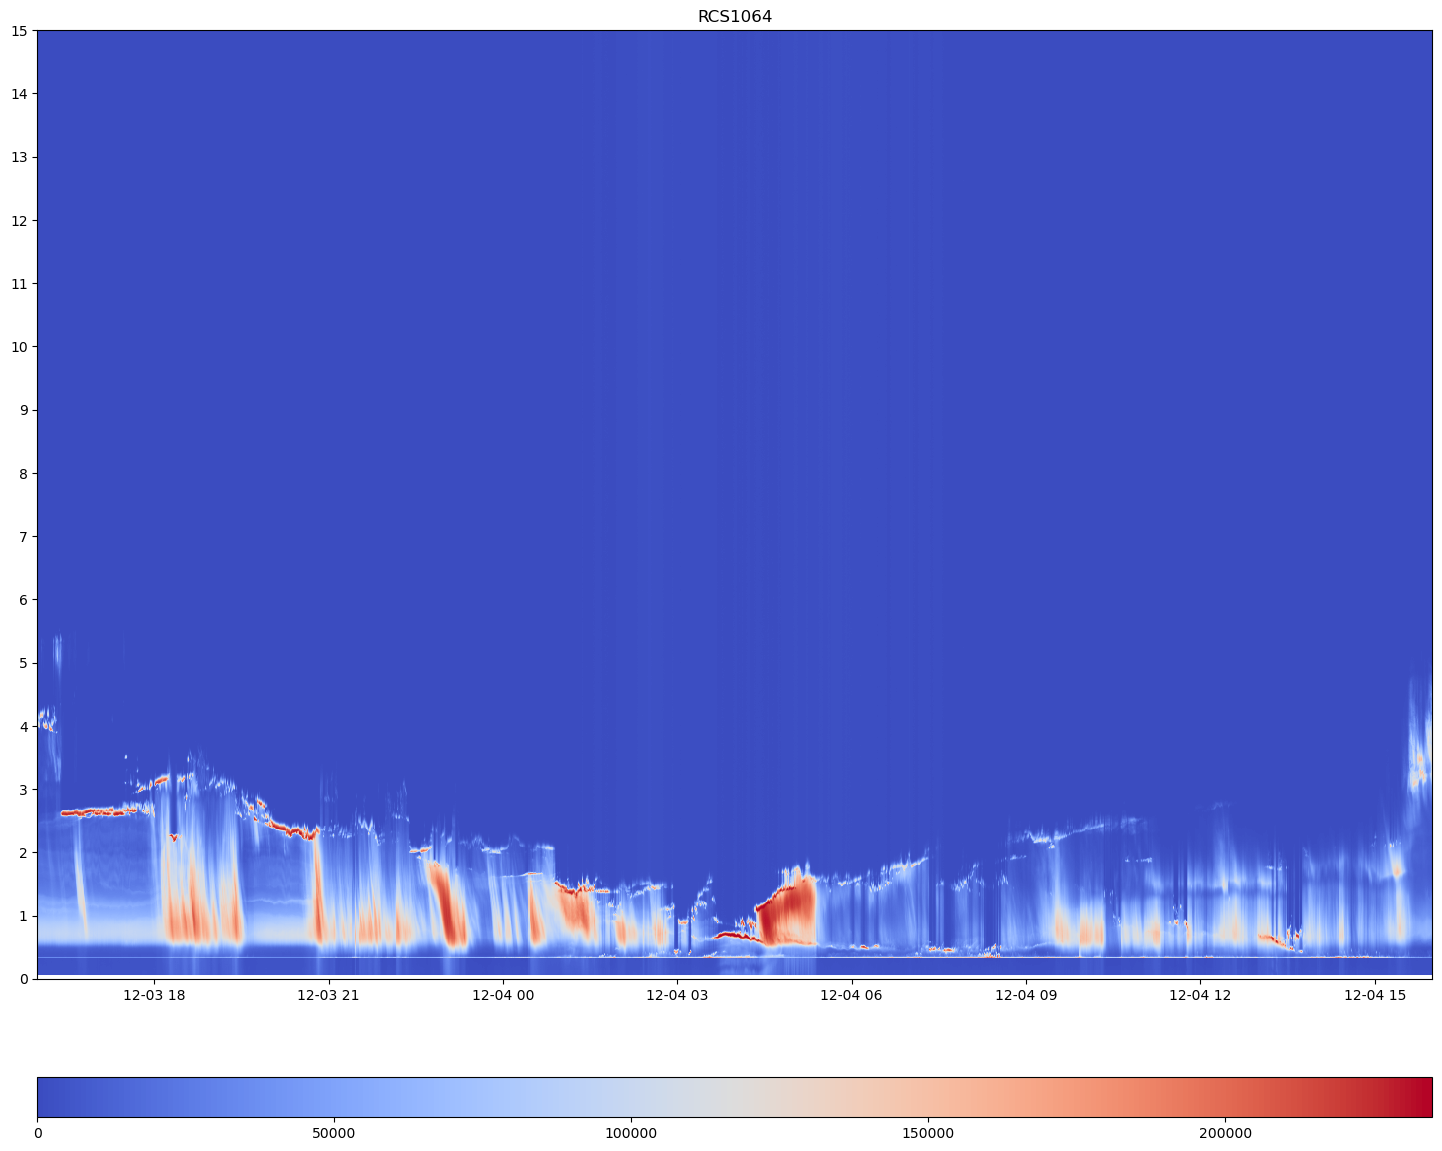

In [14]:
fig,ax=plt.subplots(figsize=(18,16))
cb=ax.pcolormesh(
    dtimes,
    hRCS1064,
    dRCS1064.T,
    cmap='coolwarm',
    vmin=0,
)
ax.set_title('RCS1064')
ax.set_yticks(np.arange(0,16))
ax.set_ylim([0,15])
plt.colorbar(cb, orientation='horizontal', extend='max', extendrect=True, extendfrac='auto', pad=0.08, aspect=35)
plt.show()

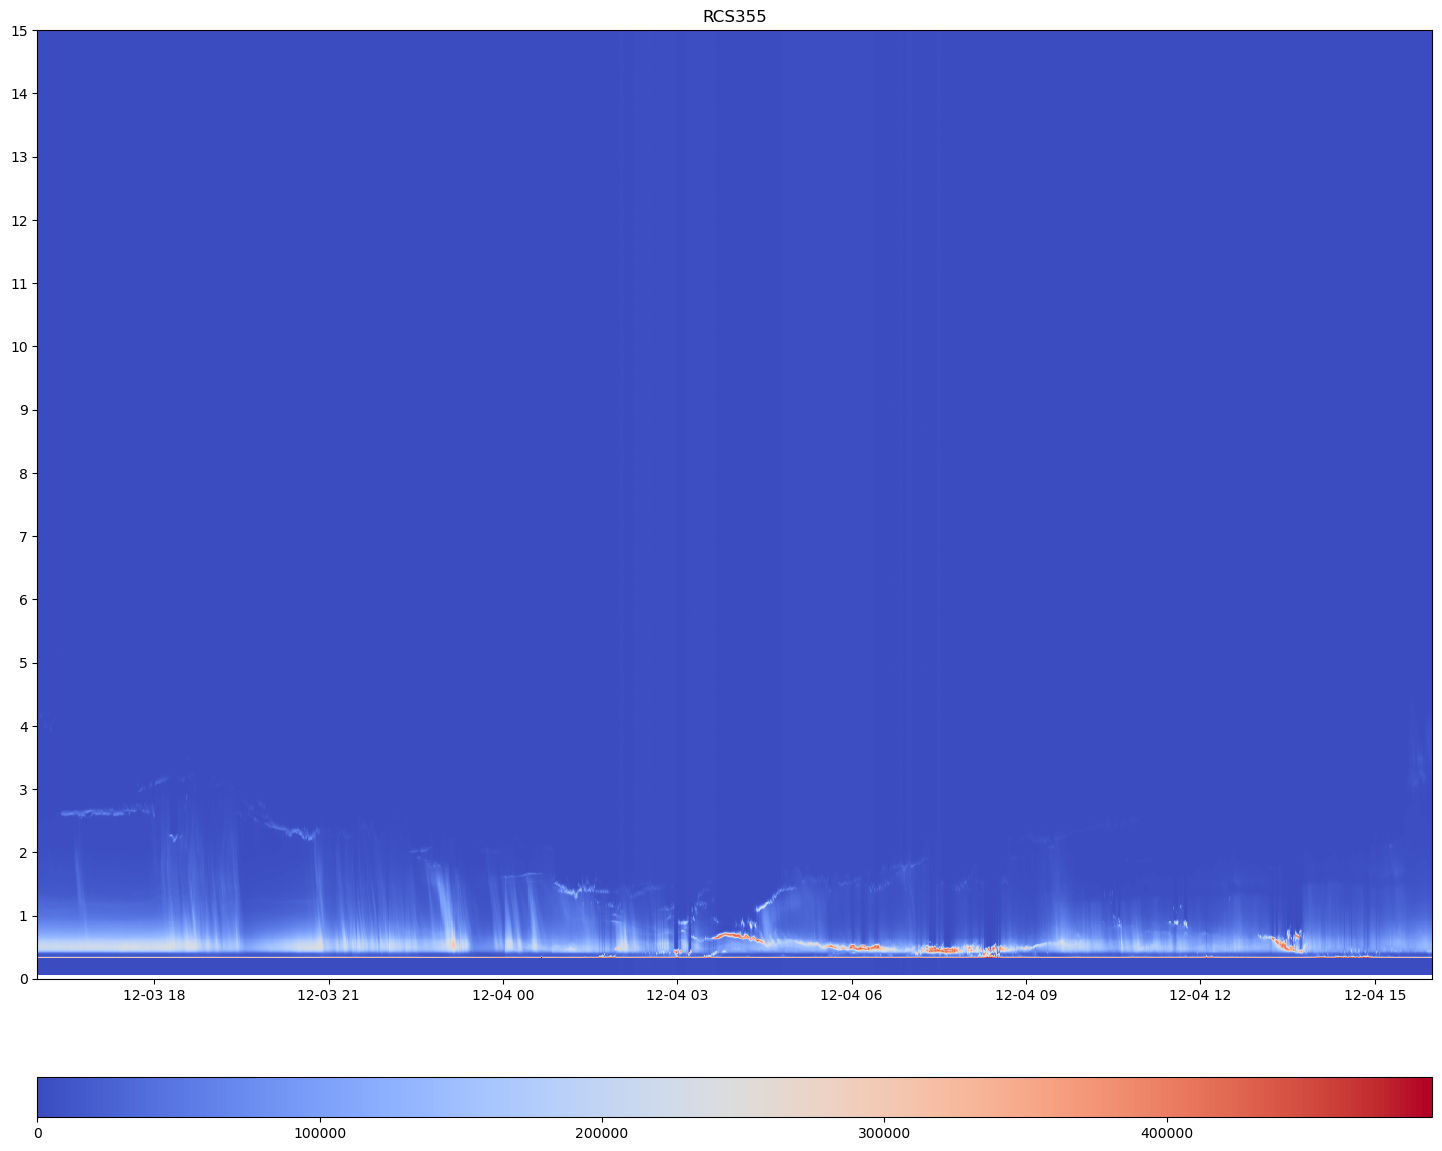

In [15]:
fig,ax=plt.subplots(figsize=(18,16))
cb=ax.pcolormesh(
    dtimes,
    hRCS355,
    dRCS355.T,
    cmap='coolwarm',
    vmin=0,
)
ax.set_title('RCS355')
ax.set_yticks(np.arange(0,16))
ax.set_ylim([0,15])
plt.colorbar(cb, orientation='horizontal', extend='max', extendrect=True, extendfrac='auto', pad=0.08, aspect=35)
plt.show()

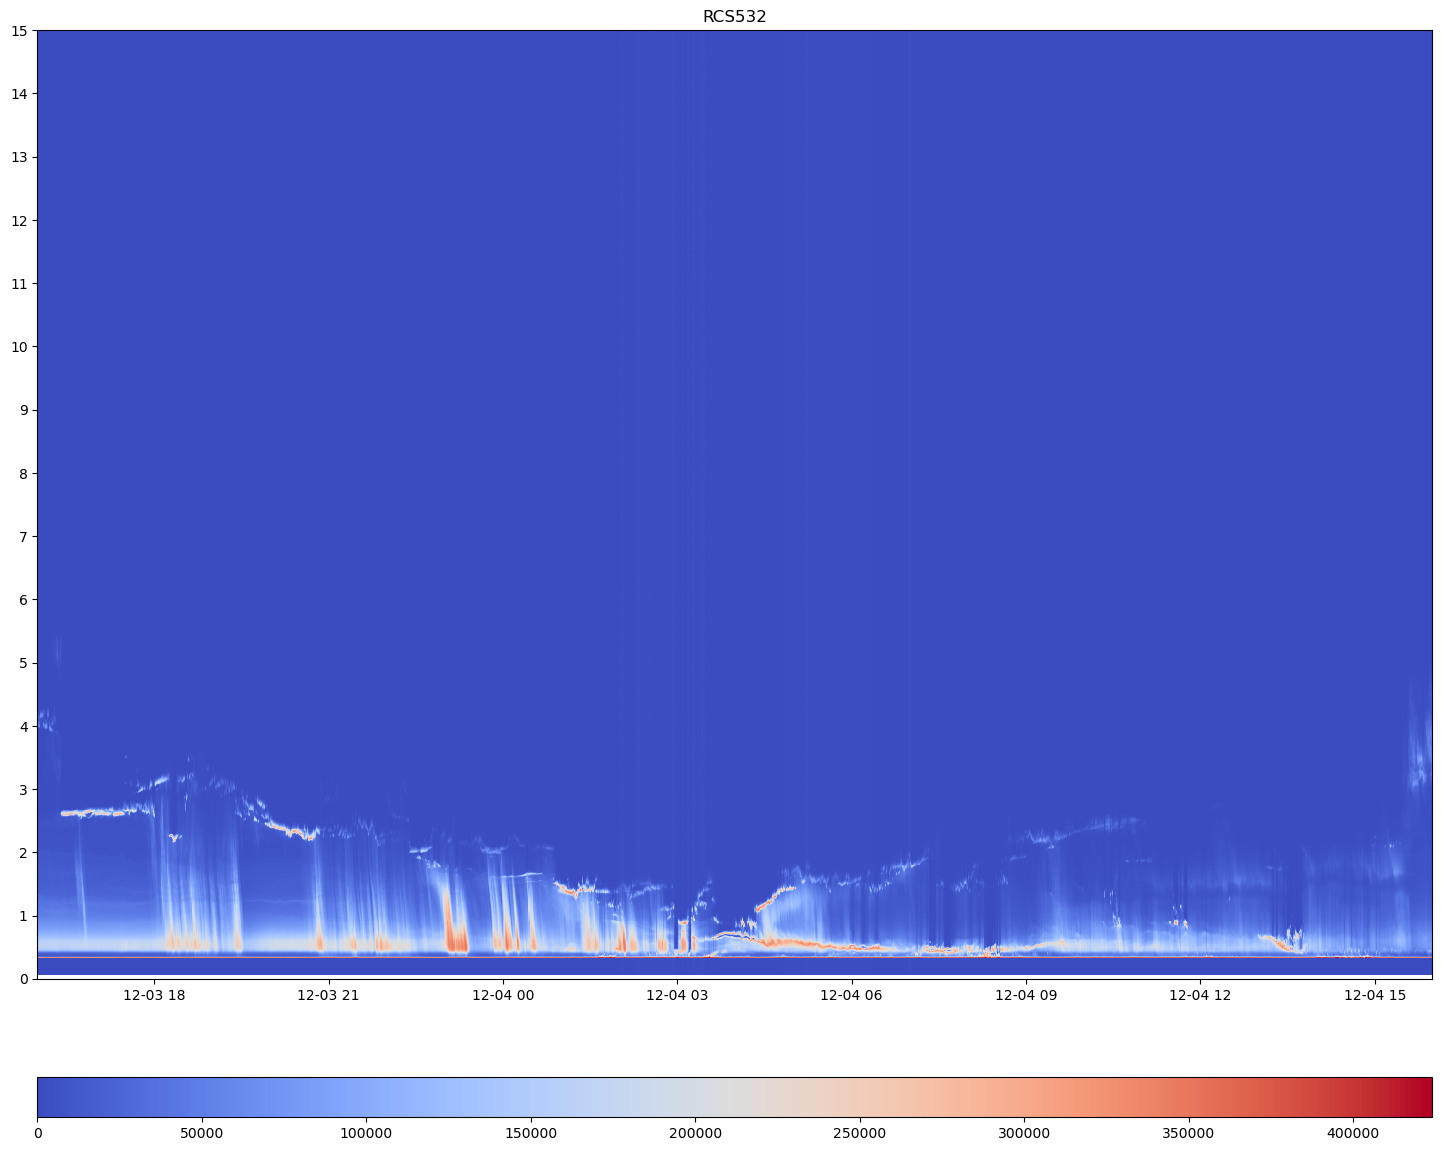

In [16]:
fig,ax=plt.subplots(figsize=(18,16))
cb=ax.pcolormesh(
    dtimes,
    hRCS532,
    dRCS532.T,
    cmap='coolwarm',
    vmin=0,
)
ax.set_title('RCS532')
ax.set_yticks(np.arange(0,16))
ax.set_ylim([0,15])
plt.colorbar(cb, orientation='horizontal', extend='max', extendrect=True, extendfrac='auto', pad=0.08, aspect=35)
plt.show()